In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pets-facial-expression-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3546787%2F6665954%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T094933Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D55a0c58578233e758075717212480b01b79d141abb8199be8e4d0f9c4edae3608190cf7a6cb8d07e48ff7fed03de8317bbdf9c7b17371f0fba9b8540b573bf91a1aaac860422a7327e9ea5318a1fde568537d1c30ef00235ec9827d45625ac0dfdf0b4df713152de37dabb5c873ea8938dad352c86d5c896f25b3e5fc7d705a1232c5c094ce55ce263bdf6ebe2a549bd031c03765b3e2619281c85f62def2e1d92c8781158a2c6bad8f08aa9b0904fc0c5718f1df0d197e67b86a2d03e6cdf6bc328e21a93209761538ce4dc2f57bd077703a73664a6e09d6f20cc9ae4c9fc4274f726fcba79b0c5207901340369a4f5607401400c7375fcb8e323eb57c7cb28'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pets-facial-expression-dataset/Other/aug-88-54.jpg
/kaggle/input/pets-facial-expression-dataset/Other/45.jpg
/kaggle/input/pets-facial-expression-dataset/Other/56.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-141-02.jpg
/kaggle/input/pets-facial-expression-dataset/Other/20.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-37-49.jpg
/kaggle/input/pets-facial-expression-dataset/Other/58.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-168-37.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-80-43.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-183-55.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-114-30.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-152-19.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-180-52.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-195-12.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-123-39.jpg
/kaggle/input/pets-facial-expression-dataset/

### Importing Libraries

In [ ]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

2024-06-20 08:52:35.975255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 08:52:35.975375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 08:52:36.090873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Preprocessing

In [ ]:
data_dir = '/kaggle/input/pets-facial-expression-dataset'
ds_name = 'Pets Facial Expression'

In [ ]:
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        if fold == 'Master Folder':
            continue

        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

filepaths, labels = generate_data_paths(data_dir)

In [ ]:
def create_df(filepaths, labels):

    series1 = pd.Series(filepaths, name= 'filepaths')
    series2 = pd.Series(labels, name='labels')
    df = pd.concat([series1, series2], axis= 1)
    return df

df = create_df(filepaths, labels)

In [ ]:
df.head()

,filepaths,labels
0,/kaggle/input/pets-facial-expression-dataset/O...,Other
1,/kaggle/input/pets-facial-expression-dataset/O...,Other
2,/kaggle/input/pets-facial-expression-dataset/O...,Other
3,/kaggle/input/pets-facial-expression-dataset/O...,Other
4,/kaggle/input/pets-facial-expression-dataset/O...,Other


In [ ]:
df['labels'] = df['labels'].replace('Angry','Hungry')

In [ ]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The Pets Facial Expression dataset has 1000 images.


In [ ]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, ds_name)

The Pets Facial Expression dataset has 4 classes


In [ ]:
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, ds_name)

The Pets Facial Expression dataset has: 

Class 'Other' has 250 images
----------------------------------------------------------------------
Class 'Hungry' has 250 images
----------------------------------------------------------------------
Class 'Sad' has 250 images
----------------------------------------------------------------------
Class 'happy' has 250 images
----------------------------------------------------------------------


In [ ]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

In [ ]:
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"The {name} dataset has no null values")

    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())


check_null_values(df, ds_name)

The Pets Facial Expression dataset has no null values


In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
num_of_examples(train_df, "Training "+ds_name)
num_of_examples(valid_df, "Validation "+ds_name)
num_of_examples(test_df, "Testing "+ds_name)
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)
classes_count(train_df, 'Training '+ds_name)
classes_count(valid_df, 'Validation '+ds_name)
classes_count(test_df, 'Testing '+ds_name)

The Training Pets Facial Expression dataset has 800 images.
The Validation Pets Facial Expression dataset has 120 images.
The Testing Pets Facial Expression dataset has 80 images.
The Training Pets Facial Expression dataset has 4 classes
The Validation Pets Facial Expression dataset has 4 classes
The Testing Pets Facial Expression dataset has 4 classes
The Training Pets Facial Expression dataset has: 

Class 'Sad' has 209 images
----------------------------------------------------------------------
Class 'happy' has 192 images
----------------------------------------------------------------------
Class 'Hungry' has 201 images
----------------------------------------------------------------------
Class 'Other' has 198 images
----------------------------------------------------------------------
The Validation Pets Facial Expression dataset has: 

Class 'Hungry' has 29 images
----------------------------------------------------------------------
Class 'Sad' has 28 images
----------------

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 800 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


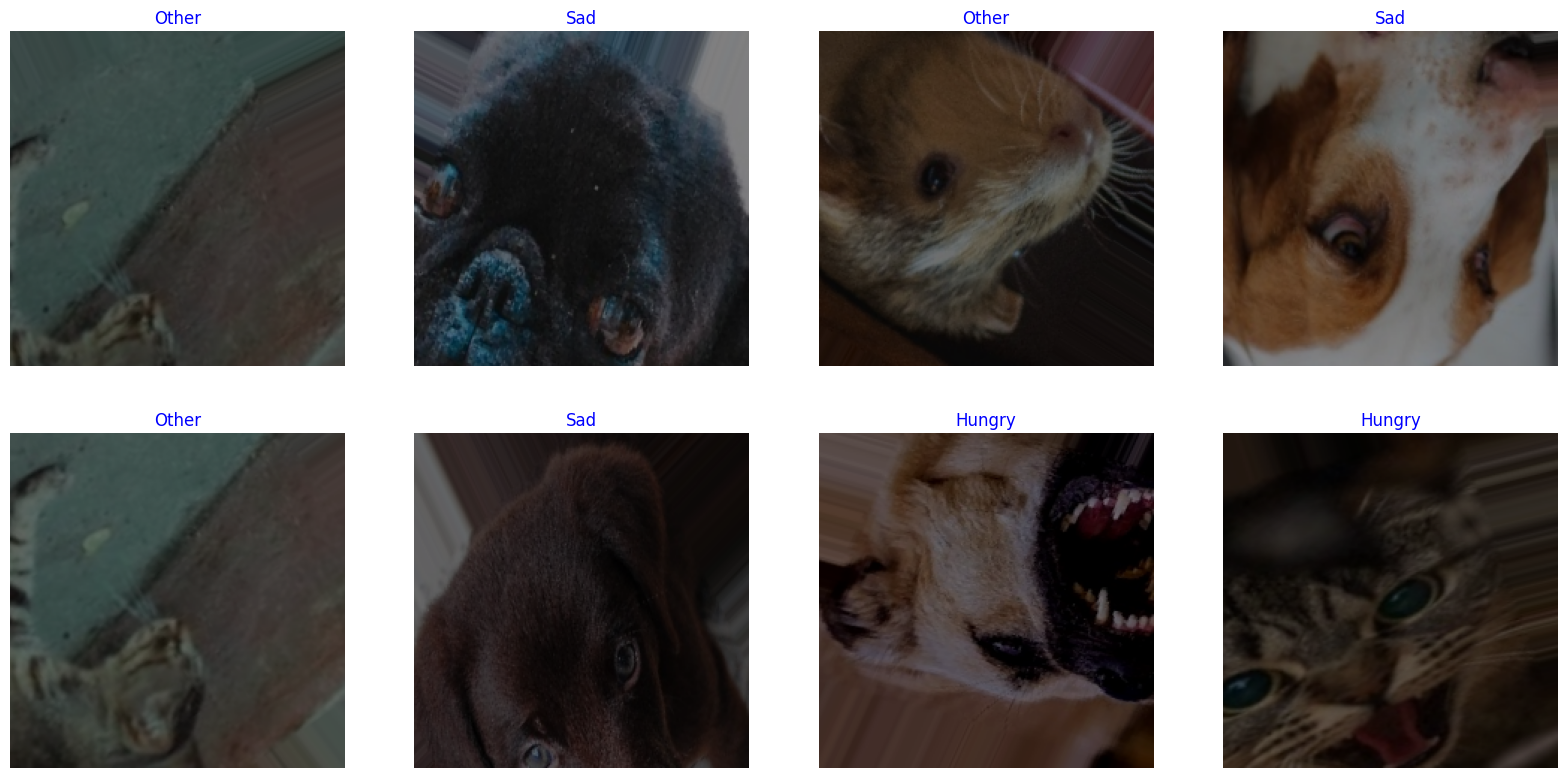

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.005), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               mode='max',
                              )

def step_decay(epoch):

     initial_lrate = 0.1
     drop = 0.5
     epochs_drop = 10.0
     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
     return lrate

lr_scheduler = LearningRateScheduler(step_decay)

In [ ]:
batch_size = 16
epochs = 125

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False)

Epoch 1/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.7313 - loss: 0.8399 - val_accuracy: 0.7750 - val_loss: 0.7347
Epoch 2/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.7155 - loss: 0.8545 - val_accuracy: 0.7917 - val_loss: 0.7195
Epoch 3/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.7351 - loss: 0.8304 - val_accuracy: 0.7917 - val_loss: 0.6977
Epoch 4/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - accuracy: 0.7774 - loss: 0.7857 - val_accuracy: 0.7667 - val_loss: 0.7743
Epoch 5/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step - accuracy: 0.7090 - loss: 0.8611 - val_accuracy: 0.8083 - val_loss: 0.7109
Epoch 6/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.7519 - loss: 0.8063 - val_accuracy: 0.7833 - val_loss: 0.7049
Epoch 7/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.7648 - loss: 0.7620 - val_accuracy: 0.7917 - val_loss: 0.7191
Epoch 8/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - accuracy: 0.7850 - loss: 0.7556 - 

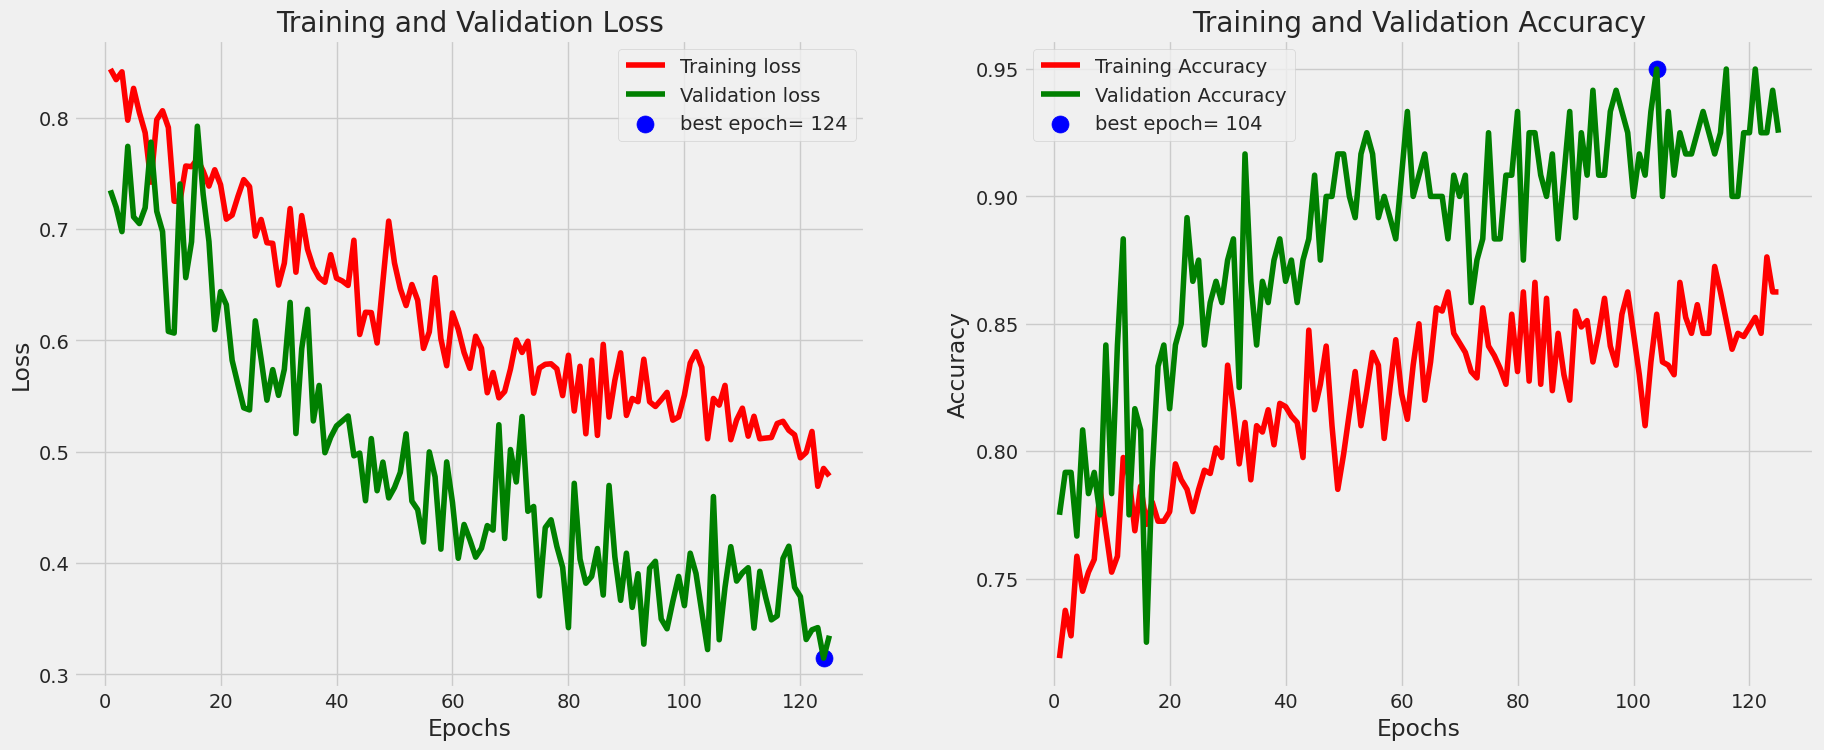

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 1.0000 - loss: 0.1984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8125 - loss: 0.5822
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9750 - loss: 0.7875
Train Loss:  0.19840386509895325
Train Accuracy:  1.0
--------------------
Test Loss:  0.7874881029129028
Test Accuracy:  0.9750000238418579


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


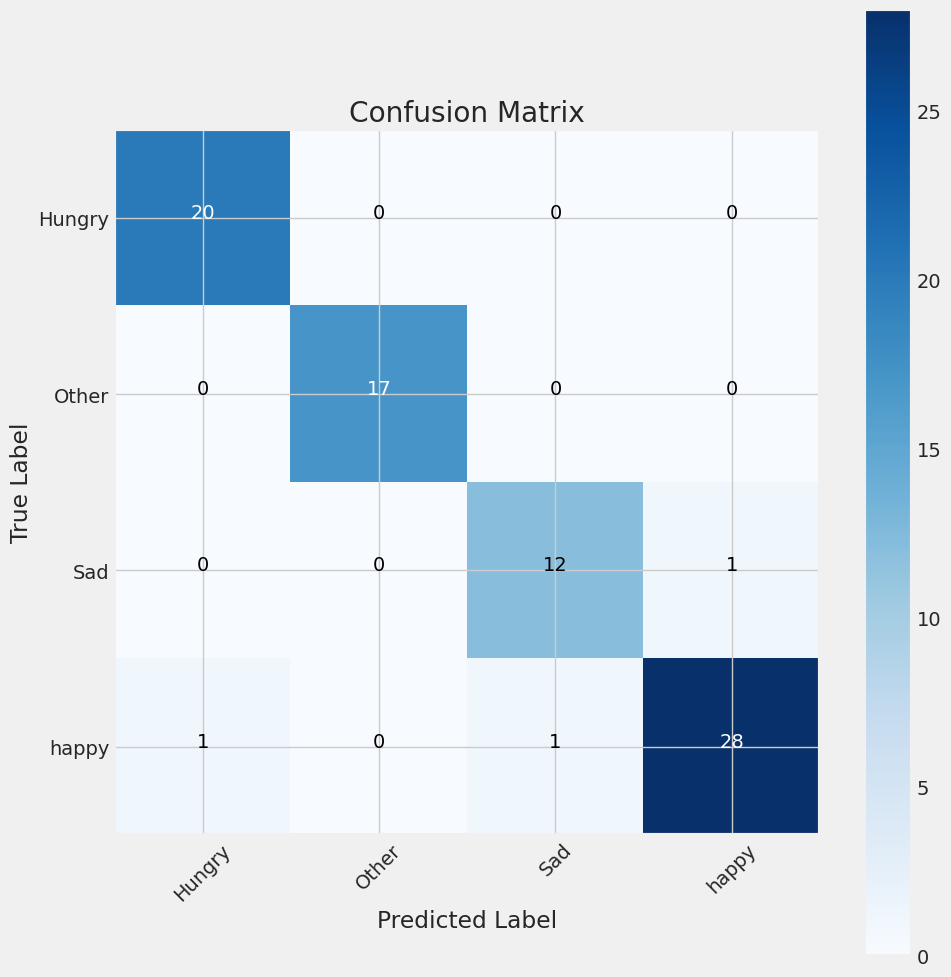

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Hungry       0.95      1.00      0.98        20
       Other       1.00      1.00      1.00        17
         Sad       0.92      0.92      0.92        13
       happy       0.97      0.93      0.95        30

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



In [ ]:
model.export('Animal Emotion')

Saved artifact at 'Animal Emotion'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_971')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137349300868848: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137349300866912: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137344311512928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137344311519792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137344311518208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137344311520496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137344311519968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137344311523840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137344303694768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137344303697936: TensorSpec(shape=(), dtype=tf.resource, name=No